In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch
from matplotlib import cm
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold, train_test_split

from concepts import concept_instances
from train_model import load_model
from utils import load_data, prepare_folders

In [3]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
# hyperparams for more accurate results, but longer computation time
max_data_size = 1000
k_fold = 5
hyper_param_size = 5
max_training_iter = 100

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = "../runs/20230927-233906/models/model_9999999.pt"
q_network = load_model(model).to(device)
layer = 5

In [6]:
concept = concept_instances['paddle x']
print(concept.name)
data = load_data()
prepare_folders(concept.path)
concept.prepare_data(data, max_size=max_data_size)

paddle x


127

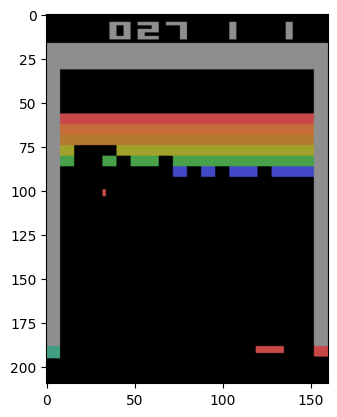

In [7]:
ex = 0
plt.imshow(concept.images_test[ex], cmap=cm.gray)
concept.data_test[ex].state_variables['paddle_x']

In [8]:
def calculate_accuracy(train_acts, train_values, test_acts, test_values):
    reg = linear_model.LogisticRegressionCV(max_iter=max_training_iter, cv=k_fold, Cs=hyper_param_size)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = accuracy_score(test_values, pred)
    return reg, 2*score-1

In [9]:
def calculate_r2(train_acts, train_values, test_acts, test_values):
    reg = linear_model.LassoCV(max_iter=max_training_iter, cv=k_fold, n_alphas=hyper_param_size)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = r2_score(test_values, pred)
    return reg, score

In [10]:
# fix test obs and values to be correct order:
paired_test = zip(concept.data_test, concept.values_test)
# sort the paired data based on concept value
sorted_data = sorted(paired_test, key=lambda data_point: data_point[1])
data_test, sorted_test_values = zip(*sorted_data)
data_test = list(data_test)
obs_test = np.array([data_point.observation for data_point in data_test])
values_test = np.array(sorted_test_values)
# assign true index to each data point
for i, data_point in enumerate(data_test):
    data_point.true_index = i

In [11]:
obs_train_flatten = concept.obs_train.reshape(len(concept.obs_train), -1)
obs_test_flatten = obs_test.reshape(len(obs_test), -1)
if concept.binary:
    reg, score = calculate_accuracy(obs_train_flatten, concept.values_train, obs_test_flatten, values_test)
else:
    reg, score = calculate_r2(obs_train_flatten, concept.values_train, obs_test_flatten, values_test)
print("score", score)
reg.intercept_

score 0.9900798911748516


92.85073530959511

### Sort on input data

In [12]:
preds = reg.predict(obs_test_flatten)
# add preds to data points
for i, data_point in enumerate(data_test):
    data_point.pred = preds[i]
data_test.sort(key=lambda data_point: data_point.pred)
# asign pred index to each data point
for i, data_point in enumerate(data_test):
    data_point.pred_index = i

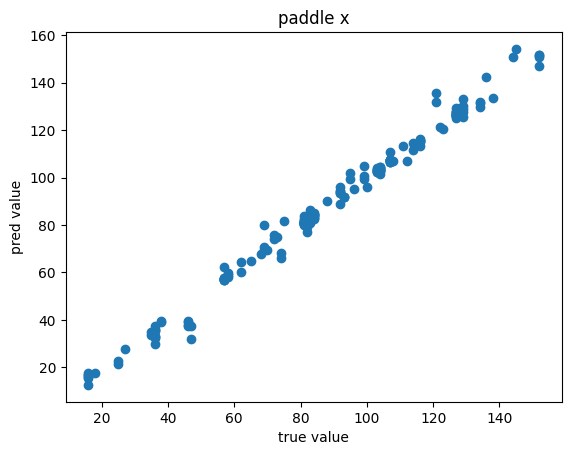

In [13]:
# plot preds vs value
plt.scatter([data_point.state_variables['paddle_x'] for data_point in data_test], [data_point.pred for data_point in data_test])
plt.xlabel("true value")
plt.ylabel("pred value")
plt.title(concept.name)
plt.show()

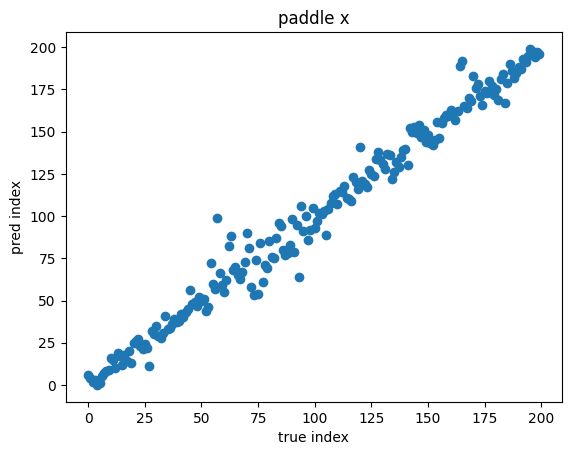

In [14]:
true_idx = [data_point.true_index for data_point in data_test]
pred_idx = [data_point.pred_index for data_point in data_test]
# plot pred index vs true index
plt.scatter(true_idx, pred_idx)
plt.xlabel("true index")
plt.ylabel("pred index")
plt.title(concept.name)
plt.show()

In [15]:
kendall_tau, _ = scipy.stats.kendalltau(true_idx, pred_idx)
print("kendall tau", kendall_tau)

spearman_rho, _ = scipy.stats.spearmanr(true_idx, pred_idx)
print("spearman rho", spearman_rho)

kendall tau 0.9226130653266331
spearman rho 0.9901762544063601


### Sort on probe

In [16]:
# now train probe on activations instead
_, train_acts = q_network(torch.tensor(concept.obs_train).to(device), return_acts=True)
train_acts = train_acts[str(layer)].cpu().detach().numpy()
train_acts = train_acts.reshape(len(train_acts), -1)

# forward obs_sorted to compare with true index
_, test_acts = q_network(torch.tensor(obs_test).to(device), return_acts=True)
test_acts = test_acts[str(layer)].cpu().detach().numpy()
test_acts = test_acts.reshape(len(test_acts), -1)

In [17]:
reg, score = calculate_r2(train_acts, concept.values_train, test_acts, values_test)
print("score", score)
preds = reg.predict(test_acts)

score 0.9474857070754611


In [18]:
# add preds to data points
for i, data_point in enumerate(data_test):
    data_point.act_pred = preds[i]
data_test.sort(key=lambda data_point: data_point.act_pred)
# asign pred index to each data point
for i, data_point in enumerate(data_test):
    data_point.act_pred_index = i

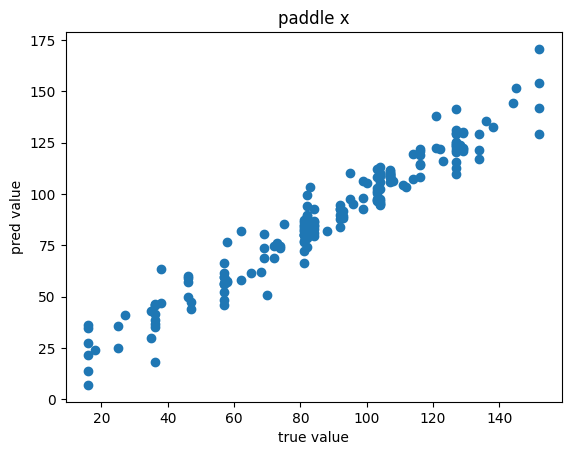

In [19]:
# plot preds vs value
plt.scatter([data_point.state_variables['paddle_x'] for data_point in data_test], [data_point.act_pred for data_point in data_test])
plt.xlabel("true value")
plt.ylabel("pred value")
plt.title(concept.name)
plt.show()

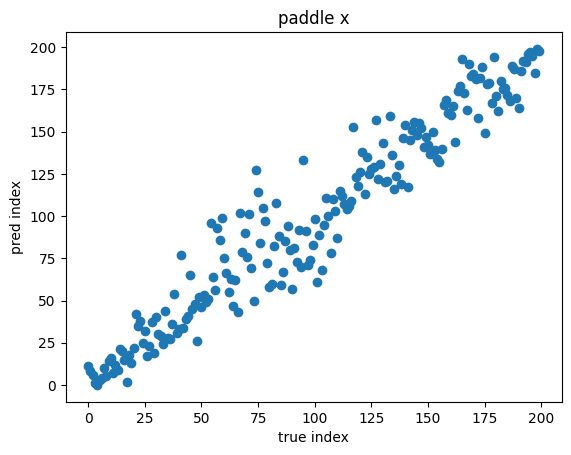

In [20]:
true_idx = [data_point.true_index for data_point in data_test]
pred_idx = [data_point.act_pred_index for data_point in data_test]
# plot pred index vs true index
plt.scatter(true_idx, pred_idx)
plt.xlabel("true index")
plt.ylabel("pred index")
plt.title(concept.name)
plt.show()

In [21]:
kendall_tau, _ = scipy.stats.kendalltau(true_idx, pred_idx)
print("kendall tau", kendall_tau)

spearman_rho, _ = scipy.stats.spearmanr(true_idx, pred_idx)
print("spearman rho", spearman_rho)

kendall tau 0.8375879396984924
spearman rho 0.964563114077852
